<a href="https://colab.research.google.com/github/Skat32/NearestAddress/blob/master/Sentiment_analysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорты 

In [ ]:
 import torch
from torch import nn
import torchtext
import numpy as np
import random, time, json
from tqdm import tqdm
import os
import re
import bz2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
!pip install transformers


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
MIN_LEN_ALLOWED = 3     # select review that has more than MIN_LEN_ALLOWED words
MAX_LEN_ALLOWED = 60    # select review that has less than MAX_LEN_ALLOWED words
N_TRAIN = 100000    # maximum number of training samples to select
N_TEST = 25000        # maximum number of test samples to select

In [ ]:
# since we have large dataset of 3.6 million reviews, we will filter only a few using this function
def text_filter(text):
    alpha = "abcdefghijklnopqrstuvwxyz "
    text = "".join([i for i in text.lower().strip() if i in alpha])
    text_len = len(text.split())
    return text_len >= MIN_LEN_ALLOWED - 1 and text_len <= MAX_LEN_ALLOWED

In [ ]:
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/amazon_reviews/test.ft.txt.bz2'

TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/amazon_reviews/train.ft.txt.bz2'

In [ ]:

# thsi function reads data from the file and selects the line that passes through the filter function
def extract_content(file_path, N=None):
    data = []
    with bz2.open(file_path, 'rt') as f:
        with tqdm(total=N) as pbar:
            while (line := f.readline()):
                line = f.readline()
                label = int(line[9])
                text = line[11:]
                if text_filter(text):
                    data.append(
                        [label, text]
                    )
                    pbar.update(1)
                if pbar.n == N: break

    return data

In [ ]:
train = extract_content(TRAIN_PATH, N=N_TRAIN)
test = extract_content(TEST_PATH, N=N_TEST)

100%|██████████| 25000/25000 [00:08<00:00, 2861.51it/s]


In [ ]:
# this function balances the dataset such that each of the 2 classes has equal number of samples in train dataset

def equalize_labels(data):
    # Count the number of tuples with label 1 and label 2
    count_1 = sum(1 for item in data if item[0] == 1)
    count_2 = sum(1 for item in data if item[0] == 2)


    # Determine the minimum count between label 1 and label 2
    min_count = min(count_1, count_2)

    # Collect tuples with label 1 and label 2 up to the minimum count
    new_data = [item for item in data if item[0] == 1][:min_count]
    new_data += [item for item in data if item[0] == 2][:min_count]

    # shuffling the data
    random.shuffle(new_data)

    return new_data

In [ ]:
train = equalize_labels(train)

In [ ]:
N_TRAIN = len(train)
N_TEST = len(test)

print("Total Train Samples:", N_TRAIN)
print("Total TEST Samples:", N_TEST)

Total Train Samples: 90606
Total TEST Samples: 25000


#Описание данных

In [ ]:
def plot_length_distribution(data, name, ax):
    data = [len(i[1].split(" ")) for i in data]
    sns.histplot(data, bins=MAX_LEN_ALLOWED-MIN_LEN_ALLOWED, color='skyblue', edgecolor='white', ax=ax)
    ax.set_xlabel('Длинна предложений')
    ax.set_ylabel('Частота')
    ax.set_title(f'Распределение длинны в {name} данных')

def plot_label_distribution(data, name, ax):
    data = pd.Series([i[0] for i in data])
    data = data.value_counts()
    data.plot(kind='bar', title=f"Распределение лейблов в {name} данных", color="skyblue", ax=ax)

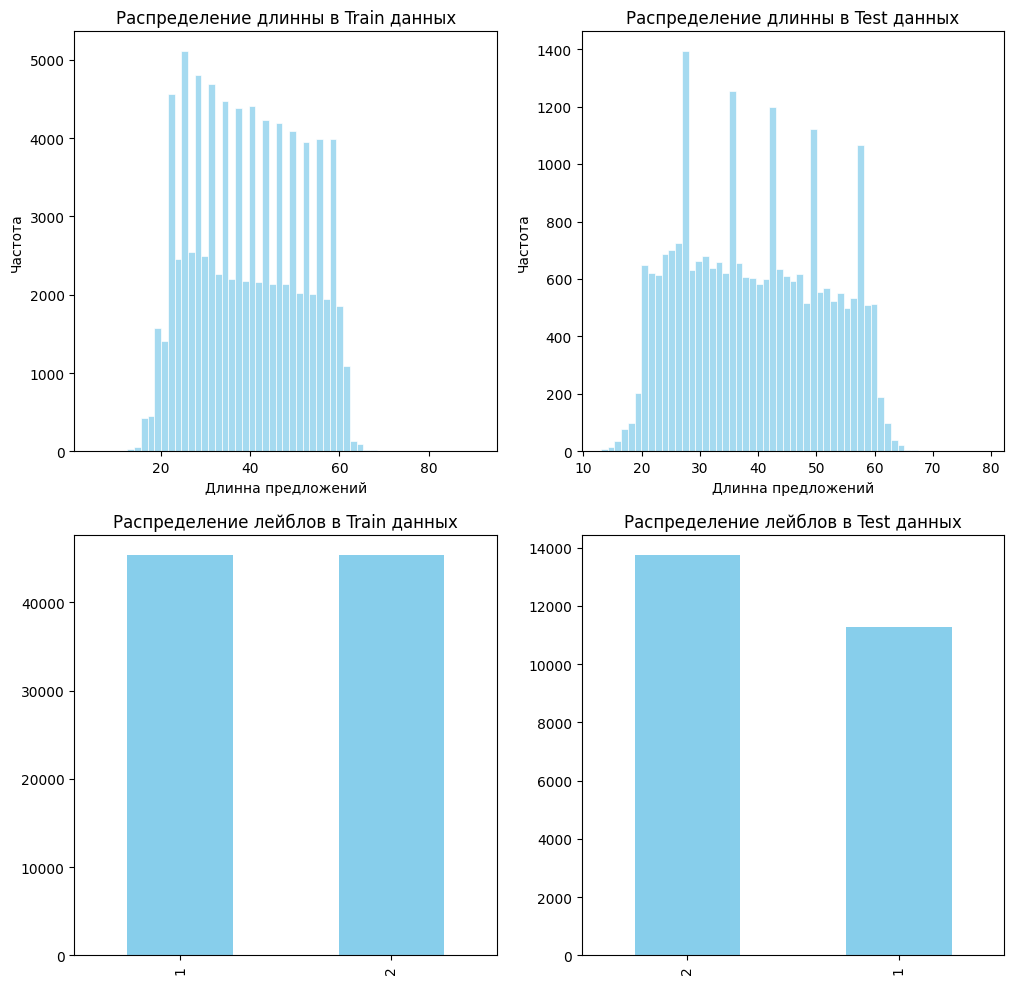

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

plot_length_distribution(train, name="Train", ax=axes[0][0])
plot_length_distribution(test, name="Test", ax=axes[0][1])
plot_label_distribution(train, name="Train", ax=axes[1][0])
plot_label_distribution(test, name="Test", ax=axes[1][1])

# Предобработка данных
- Отчистка 
- Токенизация 
- Составление словаря

In [ ]:
def clean_text(text):
    # Remove extra spaces
    text = text.strip()
    # Convert multiple spaces to single spaces
    text = re.sub('\s+', ' ', text)
    # Lowercase the text
    text = text.lower()
    # Remove punctuation marks
    text = re.sub('[^\w\s]', '', text)
    return text

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [ ]:
VOCAB_SIZE = 8_000

In [ ]:
def vocab_iter(data):
    for row in data:
        text = row[1]
        yield tokenizer(clean_text(text))

In [ ]:
print(next(vocab_iter(test)))

['works', 'fine', 'but', 'maha', 'energy', 'is', 'better', 'check', 'out', 'maha', 'energys', 'website', 'their', 'powerex', 'mhc204f', 'charger', 'works', 'in', '100', 'minutes', 'for', 'rapid', 'charge', 'with', 'option', 'for', 'slower', 'charge', 'better', 'for', 'batteries', 'and', 'they', 'have', '2200', 'mah', 'batteries']


In [ ]:
vocab = torchtext.vocab.build_vocab_from_iterator(
    vocab_iter(train),
    specials=["<OOV>"],
    max_tokens = VOCAB_SIZE,
)
vocab.set_default_index(vocab["<OOV>"])

In [ ]:
def TEXT_PIPELINE(text):
    return vocab(tokenizer(clean_text(text)))

def LABEL_PIPELINE(label):
    return label - 1

def PIPELINE(sample):
    return (LABEL_PIPELINE(sample[0]), TEXT_PIPELINE(sample[1]))       

In [ ]:
new_train = []
for item in tqdm(train):
    new_train.append(PIPELINE(item))
#train = new_train

new_test = []
for item in tqdm(test):
    new_test.append(PIPELINE(item))
#test = new_test

100%|██████████| 25000/25000 [00:03<00:00, 6787.33it/s]


In [ ]:
# this function is called when a batch is generated in from DataLoader
def collate_batch(batch):
    time_i = time.time()
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        text_list.append(torch.tensor(_text))
            
    label_list = torch.tensor(label_list, dtype=torch.float32).to(DEVICE)
    sequences =  torch.nn.utils.rnn.pad_sequence(
        text_list,
        batch_first = True,
        padding_value = PADDING_IDX
    ).to(DEVICE)

    return sequences, label_list

# this function decides how to split the dataset into batches, here sentences of similar lengths are kept in a batch together
class SortedSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size, shuffle_times):
        self.batch_size = batch_size
        self.shuffle_times = shuffle_times

        # getting sorted index
        self.idx = [i[0] for i in sorted(enumerate(data_source), key=lambda x: len(x[1]))]

    def shuffle_idx(self):
        # starting points for each batch
        offsets = list(range(0, len(self.idx), self.batch_size))[:-1]
        # shuffling inter-batch
        for i in range(self.shuffle_times):
            i1, i2 = random.choices(offsets, k=2)
            self.idx[i1:i1+self.batch_size], self.idx[i2:i2+self.batch_size] = self.idx[i2:i2+self.batch_size], self.idx[i1:i1+self.batch_size]

    def __iter__(self):
        return iter(self.idx)

    def __len__(self):
        return len(self.idx)

#Дообучение модели

In [ ]:
# Загрузка предобученной модели BERT и токенизатора
model = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model)
model = BertForSequenceClassification.from_pretrained(model, num_labels=2)  # 2 - количество классов тональности

# Подготовка данных
train_data = new_train
train_labels = [data[0] for data in train_data]
train_tokens = [data[1] for data in train_data]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
o9model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Преобразование токенизированных данных в тензоры
input_ids = [torch.tensor(tokenizer.build_inputs_with_special_tokens(tokens)) for tokens in train_tokens]
input_ids = pad_sequence(input_ids, batch_first=True)
attention_masks = torch.ones_like(input_ids)
train_labels = torch.tensor(train_labels)

In [ ]:
# Создание DataLoader
train_dataset = TensorDataset(input_ids, attention_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Обучение модели
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(1):
    model.train()
    for batch in train_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Применение модели на новых данных
test_data = new_test
test_labels = [data[0] for data in test_data]
test_tokens = [data[1] for data in test_data]

input_ids = [torch.tensor(tokenizer.build_inputs_with_special_tokens(tokens)) for tokens in test_tokens]
input_ids = pad_sequence(input_ids, batch_first=True)
attention_masks = torch.ones_like(input_ids)
test_labels = torch.tensor(test_labels)

test_dataset = TensorDataset(input_ids, attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_labels.tolist())




#Результаты

In [ ]:
# Вывод результатов
for data, prediction in zip(test, predictions):
    label = data[0]
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    print(f'Text: {data[1]}')  # Исправлено test_data[1] на data[1]
    print(f'True Label: {label}')
    print(f'Predicted Sentiment: {sentiment}')
    print('-------------------')


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Расчет метрик качества
true_labels=test_labels
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [ ]:
import matplotlib.pyplot as plt

# Вывод результатов
true_labels = test_labels
text_predictions = []
for data, prediction in zip(test, predictions):
    label = data[0]
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    text_predictions.append(sentiment)
    print(f'Text: {data[1]}')
    print(f'True Label: {label}')
    print(f'Predicted Sentiment: {sentiment}')
    print('-------------------')

# Расчет метрик качества
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Визуализация метрик
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.bar(metrics.keys(), metrics.values())
plt.title('Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()